Can we determine the average mpg of a vehicle based off the given variables? What is important to this question?

DATA: UCI Machine Learning Database: Auto: http://archive.ics.uci.edu/ml/datasets/Automobile

 

In [1]:
%%capture

!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
!pip install pdpbox
!pip install shap

# I. Wrangle Data

## Import

In [2]:
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from pandas_profiling import ProfileReport
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Define Wrangle Function

In [3]:
#Define Wrangle Function
#Pass any value through the filepath to return DF
def wrangle(filepath):

  # Read in data from url to DF
  #Name the columns based off of UCI Info
  # Index the Make col
  df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data',
                 names = ['symboling', 'normalized_losses', 'make', 'fuel_type', 
                         'aspiration', 'num_of_doors', 'body_style', 'drive_wheels', 
                         'engine_location', 'wheel_base', 'length', 'width', 
                         'height', 'curb_weight', 'engine_type', 'num_of_cylinders',
                         'engine_size', 'fuel_system', 'bore', 'stroke', 
                          'compression_ratio', 'horsepower', 'peak_rpm', 
                          'city_mpg', 'highway_mpg', 'price'], 
                   index_col = 'make')
  
  #Create target
  df['avg_mpg'] = (df['city_mpg'] + df['highway_mpg']) / 2
  
  #Drop columns we used to create target
  #Drop columns that have nothing to do with our target
  df.drop(columns = ['city_mpg', 'highway_mpg', 'normalized_losses', 
                     'num_of_doors', 'symboling', 'engine_location', 'price'], 
          inplace = True)

  # Replace the ? values with 0 in order to convert to int
  df.replace(to_replace = '?', value = '0', inplace = True)

  # Define all values that need to be numeric
  df['horsepower'] = df['horsepower'].astype(str).astype(int)
  df['bore'] = pd.to_numeric(df['bore'])
  df['stroke'] = pd.to_numeric(df['stroke'])
  df['peak_rpm'] = pd.to_numeric(df['peak_rpm'])
  # Return the DF
  return df

In [4]:
df = wrangle('filepath')

## EDA

In [5]:
df.head(10)

,fuel_type,aspiration,body_style,drive_wheels,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,avg_mpg
make,,,,,,,,,,,,,,,,,,,
alfa-romero,gas,std,convertible,rwd,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,24.0
alfa-romero,gas,std,convertible,rwd,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,24.0
alfa-romero,gas,std,hatchback,rwd,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,22.5
audi,gas,std,sedan,fwd,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,27.0
audi,gas,std,sedan,4wd,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,20.0
audi,gas,std,sedan,fwd,99.8,177.3,66.3,53.1,2507,ohc,five,136,mpfi,3.19,3.40,8.5,110,5500,22.0
audi,gas,std,sedan,fwd,105.8,192.7,71.4,55.7,2844,ohc,five,136,mpfi,3.19,3.40,8.5,110,5500,22.0
audi,gas,std,wagon,fwd,105.8,192.7,71.4,55.7,2954,ohc,five,136,mpfi,3.19,3.40,8.5,110,5500,22.0
audi,gas,turbo,sedan,fwd,105.8,192.7,71.4,55.9,3086,ohc,five,131,mpfi,3.13,3.40,8.3,140,5500,18.5


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205 entries, alfa-romero to volvo
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fuel_type          205 non-null    object 
 1   aspiration         205 non-null    object 
 2   body_style         205 non-null    object 
 3   drive_wheels       205 non-null    object 
 4   wheel_base         205 non-null    float64
 5   length             205 non-null    float64
 6   width              205 non-null    float64
 7   height             205 non-null    float64
 8   curb_weight        205 non-null    int64  
 9   engine_type        205 non-null    object 
 10  num_of_cylinders   205 non-null    object 
 11  engine_size        205 non-null    int64  
 12  fuel_system        205 non-null    object 
 13  bore               205 non-null    float64
 14  stroke             205 non-null    float64
 15  compression_ratio  205 non-null    float64
 16  horsepower         

In [7]:
df.describe()

,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,avg_mpg
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.264780,3.191902,10.142537,103.239024,5075.365854,27.985366
std,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.535268,0.549625,3.972040,40.832470,694.650771,6.666038
min,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,0.000000,0.000000,7.000000,0.000000,0.000000,15.000000
25%,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.130000,3.100000,8.600000,70.000000,4800.000000,22.500000
50%,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,27.000000
75%,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,32.000000
max,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,51.500000


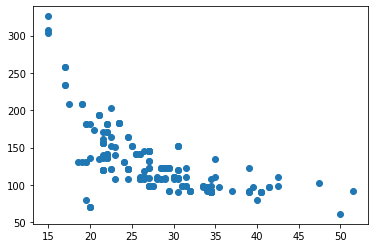

In [32]:
plt.scatter(df['avg_mpg'], df['engine_size']);

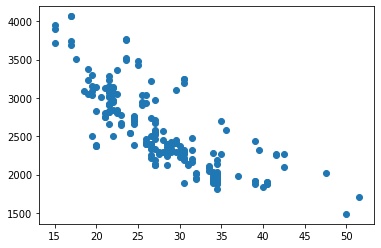

In [33]:
plt.scatter(df['avg_mpg'], df['curb_weight']);

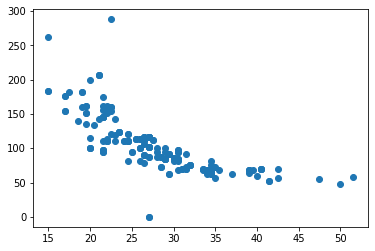

In [34]:
plt.scatter(df['avg_mpg'], df['horsepower']);

Distribution type seems to be **Normal Distribution**. Could consider a little right skewed, but overall, would call normal.

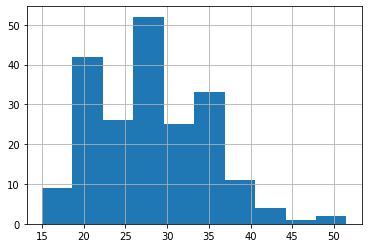

In [10]:
df['avg_mpg'].hist();

In [ ]:
ProfileReport(df)

### EDA Analysis

After exploring the data, I found that we were running with 25 different features. We needed to determine which features contributed to the average mpg of a vehicle, and which features were not necessary. Consulting with a mechanic friend of mine and using my own mechanical background, we made the determination that things such as: 
- number of doors
- Normalized Losses
- Symboling
- Price

were unnecessary as they did not contribute to vehicle function. I then dug into my ProfileReport and noticed that the values for engine location were highly correlated, as only 3 vehicles had an engine in the rear. 

Upon closer inspection of the DF, I noticed that there were multiple columns that were objects that should be made into numerical data. When we use a onehot, it will make our data much more complicated than it needs to be too. These columns were:

- Bore
- Horsepower
- Stroke
- Peak RPM

Data now looks a lot cleaner and should fit together better.

# II. Split Data

### Split the **target vector** from the **feature matrix**

In [12]:
# Define my target
target = 'avg_mpg'

# Create Feature Matrix : Always 2-D
X = df.drop(columns = target)

# Create Target Vector : Always 1-D
y = df[target]

## Create ***train_test_split*** for training, validation, and testing data

In [13]:
#Create first test split. This will create testing data. 
X_train1, X_test, y_train1, y_test = train_test_split(X,y, random_state = 42,
                                                      test_size = 0.2)

In [14]:
# Create second test split. This will create training and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, 
                                                  random_state = 42,
                                                  test_size=0.2)

In [15]:
#Double check that I split the data properly. 
#Length of train,val,test data should equal the original length of the DF
assert len(X_train) + len(X_test) + len( X_val) == len(df)
assert len(y_train) + len(y_test) + len(y_val) == len(df)

# III. Establish Baseline

In [16]:
#Create vector of predicted values
y_pred = [y_train.mean()] * len(y_train)

#Calculate our baseline error. 
baseline_mae = mean_absolute_error(y_train, y_pred)
print('Mean Average MPG is:', y_train.mean())
print('Baseline MAE is:', baseline_mae)

Mean Average MPG is: 27.53435114503817
Baseline MAE is: 5.114620360118874


# IV. Build Model(s)

In [17]:
#Instantiate Model
# Create Pipeline for Linear Regression
model_lr = make_pipeline(OneHotEncoder(use_cat_names=True),
                         StandardScaler(),
                         LinearRegression()
                         )

#Fit the model
model_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['fuel_type', 'aspiration', 'body_style',
                                     'drive_wheels', 'engine_type',
                                     'num_of_cylinders', 'fuel_system'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [18]:
# Create Model Pipeline
model_r = make_pipeline(OneHotEncoder(use_cat_names=True),
                          StandardScaler(),
                         Ridge(normalize=False)
                         )

# Fit the model
model_r.fit(X_train, y_train);

In [19]:
# Instantiate XGBooster pipeline
model_xgb = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    XGBRegressor(random_state=42,n_jobs=-1)
)

# Fit the model
model_xgb.fit(X_train, y_train)



[21:54:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['fuel_type', 'aspiration', 'body_style',
                                     'drive_wheels', 'engine_type',
                                     'num_of_cylinders', 'fuel_system'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=-1,
                              nthread=None, o

# V. Check Metrics

In [20]:
#Calculate Linear Regression Training and Validation MAE using predicted values
model_lr_training_mae = mean_absolute_error(y_train, model_lr.predict(X_train))
model_lr_validation_mae = mean_absolute_error(y_val, model_lr.predict(X_val))

#Print and check against Baseline
print('Training MAE is:', model_lr_training_mae)
print('Validation MAE is:', model_lr_validation_mae)

Training MAE is: 1.3766432411960645
Validation MAE is: 1.5564593528958488


In [21]:
# Calculate Ridge Regression Training and Validation MAE using predicted values
model_r_training_mae = mean_absolute_error(y_train, model_r.predict(X_train))
model_r_validation_mae = mean_absolute_error(y_val, model_r.predict(X_val))

# Print and check against Linear Regression Model
print('Training MAE is:', model_r_training_mae)
print('Validation MAE is:', model_r_validation_mae)

Training MAE is: 1.388567565042065
Validation MAE is: 1.5830296085249616


In [22]:
# Calculate XGBoost Training and Validation MAE using predicted values
model_xgb_training_mae = mean_absolute_error(y_train, model_xgb.predict(X_train))
model_xgb_validation_mae = mean_absolute_error(y_val, model_xgb.predict(X_val))

# Print and check against other models
print('Training MAE is:', model_xgb_training_mae)
print('Validation MAE is:', model_xgb_validation_mae)

Training MAE is: 0.3117630718318561
Validation MAE is: 1.0261935031775273


Calculate R2 Metrics for each Model

In [23]:
#Calculate and check R2 validation score. Should be close to 1
model_lr_r2 = model_lr.score(X_val, y_val)
model_r_r2 = model_r.score(X_val,y_val)
model_xgb_r2 = model_xgb.score(X_val, y_val)

print('Linear Regression R^2', model_lr_r2)
print('Ridge Regression R^2:', model_r_r2)
print('XGBooster Regression R^2', model_xgb_r2)

Linear Regression R^2 0.8779141427922542
Ridge Regression R^2: 0.8654956621772232
XGBooster Regression R^2 0.9060154311206443


Explore our parameters and see if we can make the score any better

In [24]:
#This will edit X_train. Will need to rerun the instantiating cells for X again.
for c in X_train.columns:
    if X_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[c].values))
        X_train[c] = lbl.transform(list(X_train[c].values))

xgb1 = XGBRegressor()
parameters = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    7.5s finished


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                        

Through HyperParameter Tuning, we have seen that our model is best fit the way it is. 

In [25]:
#Use best fitting model with testing data and see how we do
model_xgb_test_mae = mean_absolute_error(y_test, model_xgb.predict(X_test))

print('Test MAE is:', model_xgb_test_mae)

Test MAE is: 1.5591882612647079


# VI. Communicate Results

We have created a model which can predict the Average Mile Per Gallon consumption of a vehicle given our X variables with a (+) or (-) of **1.56mpg** 

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131 entries, dodge to saab
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fuel_type          131 non-null    int64  
 1   aspiration         131 non-null    int64  
 2   body_style         131 non-null    int64  
 3   drive_wheels       131 non-null    int64  
 4   wheel_base         131 non-null    float64
 5   length             131 non-null    float64
 6   width              131 non-null    float64
 7   height             131 non-null    float64
 8   curb_weight        131 non-null    int64  
 9   engine_type        131 non-null    int64  
 10  num_of_cylinders   131 non-null    int64  
 11  engine_size        131 non-null    int64  
 12  fuel_system        131 non-null    int64  
 13  bore               131 non-null    float64
 14  stroke             131 non-null    float64
 15  compression_ratio  131 non-null    float64
 16  horsepower         131 non

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd8920702d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd8919f2f10>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


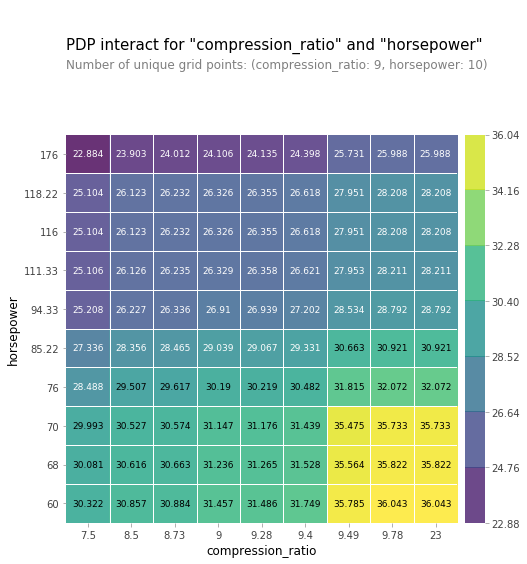

In [27]:
# Seperate features we want to graph
features = ['compression_ratio','horsepower']

#Build outline for graph
interact = pdp_interact(model_xgb,
                        dataset = X_val,
                        model_features = X_val.columns,
                        features=features)

#Display graph
pdp_interact_plot(interact,plot_type='grid',feature_names = features)

In [28]:
#This will edit X_train. Will need to rerun the instantiating cells for X again.
for c in X_train.columns:
    if X_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[c].values))
        X_train[c] = lbl.transform(list(X_train[c].values))
# Instantiate XGBR Class
model_xgb1 = XGBRegressor()

#Fit the model
model_xgb1.fit(X_train, y_train)

[21:55:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [29]:
# Seperate single sample data
sample = X_train.head(25)

In [30]:
explainer = shap.TreeExplainer(model_xgb1)
shap_values = explainer.shap_values(sample)

shap.initjs()
shap.force_plot(base_value=explainer.expected_value,
                shap_values = shap_values,
                features=sample)
